Copyright 2024 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

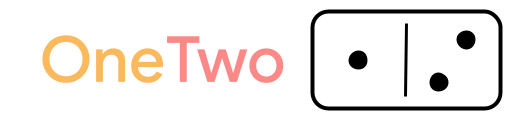

This colab illustrates how to use the [OneTwo](https://github.com/google-deepmind/onetwo) library.

# Installation

In [ ]:
# Install OneTwo
!pip install git+https://github.com/google-deepmind/onetwo

# Connect to an LLM and run a prompt

As of the initial release, we support connections to the following models (more will be added soon):
- Gemini API
- Gemma running locally
- Gemma running on a OneTwo model server



## Gemini API

If you have not used the Gemini API before, you will need to first create an account and API key following the instructions on https://ai.google.dev/. Then either copy-paste your API key into the placeholder below, or store it in the 'GOOGLE_API_KEY' environment variable.

In [ ]:
import os
from onetwo.backends import gemini_api

# You can specify your API key either here or as an environment variable.
GOOGLE_API_KEY=None

if not GOOGLE_API_KEY and 'GOOGLE_API_KEY' not in os.environ:
  raise ValueError(
      'GOOGLE_API_KEY must be specified either here or in the environment.')

backend = gemini_api.GeminiAPI(api_key=GOOGLE_API_KEY)
backend.register()

## Gemma (running locally)

The [Gemma](https://ai.google.dev/gemma) family of open weights models ([GitHub](https://github.com/google-deepmind/gemma)) can be obtained from the following repositories:
- Vertex Model Garden: https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/335
- Kaggle: https://www.kaggle.com/models/google/gemma/
- HuggingFace: https://huggingface.co/docs/transformers/en/model_doc/gemma

As an example, below are the instructions for downloading a Gemma model from Kaggle. If you have not used Kaggle before, you will need to first create a Kaggle account and API key (a.k.a. API token) following the instructions on https://www.kaggle.com/docs/api. Then copy-paste your username and API key into the placeholders below.

If you have not used Gemma on Kaggle before, you will also need to go to https://www.kaggle.com/models/google/gemma/ and click "Request access" to complete the consent form before proceeding.

In [ ]:
# Install kaggle
! pip install kaggle
! pip install kagglehub

In [ ]:
import kagglehub
from kagglehub import auth

auth.set_kaggle_credentials(
    username='YOUR_KAGGLE_USERNAME', api_key='YOUR_KAGGLE_API_KEY'
)
kagglehub.login()

In [ ]:
import os

VARIANT = '2b-it'  # @param ['2b', '2b-it', '7b', '7b-it'] {type:"string"}
weights_dir = kagglehub.model_download(f'google/gemma/Flax/{VARIANT}')

checkpoint_path = os.path.join(weights_dir, VARIANT)
vocab_path = os.path.join(weights_dir, 'tokenizer.model')

Once you have downloaded a copy of the model, you can create a OneTwo backend using this model as follows:

In [ ]:
from onetwo.backends import gemma_local

backend = gemma_local.Gemma(
    checkpoint_path=checkpoint_path, vocab_path=vocab_path
)
backend.register()

## Gemma (running on a separate server)

While experimenting, you may not want to have to reload the model every time you change something in your code, so it can be convenient to set up the Gemma model to run in a separate process or even on a separate machine.

We provide a model server script for that.

### Server setup

In order to set up a server, you can use the `run_model_server.py` script. For example you can create a server that serves a Gemma model.

```shell
CHECKPOINT_PATH="PATH_TO_THE_CHECKPOINT_DIR"
VOCAB_PATH="PATH_TO_THE_VOCAB_FILE"

python run_model_server.py \
  --backend_module="onetwo.backends.gemma_local" \
  --backend_class="Gemma" \
  --backend_params="{\"checkpoint_path\": \"$CHECKPOINT_PATH\", \"vocab_path\": \"$VOCAB_PATH\"}" \
  --port=8888
```

You can also simply create your own python code to load a model locally or connect to a remote model and run as a simple web server using code that looks like:

```python
import uvicorn

def main(args):
  # Code to create the backend connection (local or remote).
  backend = ...
  backend.register()

  # Starting a simple server piping requests to the registered backend.
  uvicorn.run(
      'onetwo.backends.model_server:ModelServer',
      host='0.0.0.0',
      port=8888,
      factory=True,
  )
```

### Client connection

Once your server is set up, on the client side, you can connect to it using the onetwo_api module.

If you have set up a server as described above, you can uncomment the code below and copy-paste your server hostname into the placeholder.

In [ ]:
# from onetwo.backends import onetwo_api

# backend = onetwo_api.OneTwoAPI(endpoint='http://SERVER_HOST_NAME:8888')
# backend.register()

## Test the connection

Here is some example code to issue a generate_text request to the currently registered backend.

In [ ]:
from onetwo import ot
from onetwo.builtins import llm

e = llm.generate_text(
    'Q: What are three not so well known cities in france?\nA:',
    stop=['Q:'],
    max_tokens=20,
)
print(ot.run(e))

## Saving/Loading cache on disk

When creating a backend, one can associate a cache file to it.
This allows one to store and retrieve previously executed requests.

In [ ]:
import os

CACHE_FILE = '/tmp/gemini_backend_cache.json'

backend = gemini_api.GeminiAPI(
    api_key=API_KEY,
    cache_filename=CACHE_FILE,
)
backend.register()
if os.path.isfile(CACHE_FILE):
  print(f'Loading cache from {CACHE_FILE}')
  backend.load_cache()
else:
  print(f'Cache file does not exist: {CACHE_FILE}')

e = llm.generate_text(
    'Q: What are three not so well known cities in france?\nA:',
    stop=['Q:'],
    max_tokens=20,
)
print(ot.run(e))

backend.save_cache(overwrite=True)